# Workload Effect on Pitcher Injury

## Goal: 
Determine if we can find:
1) Maximize the predictability of the probability of a pitcher getting injured

## Background:
For our (1) goal, we want to predict the probability that a pitcher will get injured as a result of workload, rest (or lack thereof), distance traveled, etc. Essentially, given some features regarding what the pitcher has recently done, we can determine the probability that he'll get injured, should he play the next game. In a sense, we're trying to come up with a solution for teams', such that, based on the probability that results from the features we mentioned, a manager or top decision-maker would make judgdment (e.g., our probability induces a certain threshold such that meeting that threshold induces the idea of resting that pitcher instead of letting him pitch and risk an injury). 

Now we understand that there is one glaring issue, and that is that there are many other confounding factors that induce an injury that might not necessarily *be* correlated with workload (e.g., the ball comes back to the pitcher and hits them and takes them out, the pitcher's form wasn't quite right and it caused an inury as a result of straining your body to come up with velo). To account for this, we want to focus on types of injuries that we are confident *are* correlated with workload, and we'll use scientific evidence to support this (e.g., torn UCL). The reason to avoid those other "freak" types of injuries is that they are a potential source of noise/bias as mentioned previously, some injuries are just not a result of workload, meaning it is entirely possible that our models could *learn* from these types of injuries and determine some kind of relationship with the probability of an injury, which we would not want. 

To approach this problem, we want to take a step back and view this problem from another lens. That being: Industrial Engineering. Essentially, we want to view pitchers as "machines," and as a result, we want to estimate the "failure" rate (injury rate) of these "machines" as a function of workload cycles, rest, and travel. Meaning, we want to quantitatively come up with policies for the pitcher that are analogous to process optimizations. As we want to identify when the injury risk of these pitchers accelerate, such that we can prevent this *potential* injury in order to maximize pitcher usage, and minimize any waste, cost, or downtime.

In future iterations, we'd be interested in learning about *true* causal effects in terms of pitcher injuries, and whether or not the factors we talked about (e.g., workload, rest, etc.) have that kind of effect.

## Methodology:


To approach this problem, we first want to understand if there *are* any type of relationships between these workload variables and injury probability. 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybaseball as pyb
import requests

pd.set_option('display.max_columns', None)

In [8]:
mlb_injuries = pd.read_csv('mlb_injuries.csv')
mlb_injuries

,rank,player,pos,team,il_type,injury,start_date,end_date,reason_raw,year
0,1,Miguel Cabrera,DH,DET,10-Day IL,Hamstring,2018-05-04,2018-06-01,10-Day IL - Hamstring: 5/4/18-6/1/18 10-Day I...,2018
1,1,Miguel Cabrera,DH,DET,10-Day IL,Hamstring,2018-06-13,2018-10-01,10-Day IL - Hamstring: 5/4/18-6/1/18 10-Day I...,2018
2,2,Jacoby Ellsbury,CF,NYY,60-Day IL,Oblique,2018-03-29,2018-10-01,60-Day IL - Oblique: 3/29/18-10/1/18,2018
3,3,Yoenis Céspedes,LF,NYM,10-Day IL,Hip,2018-05-16,2018-07-20,10-Day IL - Hip: 5/16/18-7/20/18 60-Day IL - ...,2018
4,3,Yoenis Céspedes,LF,NYM,10-Day IL,Hip,2018-07-24,2018-10-01,10-Day IL - Hip: 5/16/18-7/20/18 60-Day IL - ...,2018
...,...,...,...,...,...,...,...,...,...,...
6605,628,Cade Horton,SP,CHC,15-Day IL,Ribs,2025-09-25,2025-09-28,15-Day IL - Ribs: 9/25/25-9/28/25,2025
6606,629,Everson Pereira,OF,TB,10-Day IL,Back,2025-09-26,2025-09-28,10-Day IL - Back: 9/26/25-9/28/25,2025
6607,630,Brett Baty,2B,NYM,10-Day IL,Oblique,2025-09-27,2025-09-28,10-Day IL - Oblique: 9/27/25-9/28/25,2025
6608,631,Nick Frasso,SP,LAD,60-Day IL,Undisclosed,2025-09-27,2025-09-28,60-Day IL - Undisclosed: 9/27/25-9/28/25,2025


In [9]:
def get_name_birth(id: int):
    """
    A get function to find attributes of each player based on their mlb id using MLB's Stats API

    Note: you have to be online to run this
    """
    url = f"https://statsapi.mlb.com/api/v1/people/{id}"
    r = requests.get(url).json()
    list_attr = [r['people'][0]['birthDate'].split('-')[0], 
                 r['people'][0]['primaryPosition']['abbreviation'], 
                 r['people'][0]['birthCountry'], 
                 r['people'][0]['height'], 
                 r['people'][0]['weight'],]
    list_attr[3] = int(list_attr[3].split(' ')[0].strip("'"))*12 + int(list_attr[3].split(' ')[1].strip("\"")) ## changes 6'2" into inches
    list_attr[4] = float(list_attr[4]) ## makes sure weight is a number
    return list_attr

In [10]:
def load_year_data(year: int):
    """
    Creates the relevant pitcher data for each given year
    Should take about 7-8 min to run for individual year
    """
    df = pyb.statcast(f'{year}-03-01', f'{year}-11-30').copy() ## chooses the specific year
    ## cleans up the pitch by pitch data for that season
    df = df[df['game_type'] == 'R'].sort_values(by=['game_date', 'game_pk', 'inning', 'at_bat_number'], ascending=True).reset_index(drop=True).copy()
    df['game_date'] = pd.to_datetime(df['game_date'])
    ## adds the pitch group to simplify pitch usage
    fastball_pitches = ['FF', 'FC', 'SI']
    breaking_pitches = ['CU', 'KC', 'SC', 'SL', 'SV', 'ST']
    offspeed_pitches = ['CH', 'FO', 'FS']
    df['pitch_group'] = df['pitch_type'].apply(lambda x: 'Fastball' if x in fastball_pitches 
                                            else 'Breakingball' if x in breaking_pitches 
                                            else 'Offspeed' if x in offspeed_pitches 
                                            else 'Other')

    ## finds all of the appearances each pitcher made in that season as well as the number of pitches thrown
    df_pitcher_games = df.groupby(['player_name', 'pitcher', 'p_throws', 'game_pk', 'game_date'], as_index=False).agg(pitches_thrown=('pitcher', 'count')).copy()
    df_pitcher_games = df_pitcher_games.sort_values(['player_name', 'game_date']).reset_index(drop=True).copy()

    ## adds an indicator if the pitcher is right handed or not
    df_pitcher_games['p_throws'] = (df_pitcher_games['p_throws'] == 'R').astype(int)
    ## creates the indicator of what the current season is
    df_pitcher_games['season'] = df_pitcher_games['game_date'].dt.year
    ## finds the previous appearence made for each current date 
    df_pitcher_games['last_appearence_date'] = (df_pitcher_games.groupby('pitcher')['game_date'].shift(1))
    ## finds the number of pitches that were thrown in the previous appearance made
    df_pitcher_games['pitches_last_appearence'] = (df_pitcher_games.groupby('pitcher')['pitches_thrown'].shift(1))
    ## the number of rest days the pitcher had before their current appearence
    df_pitcher_games['days_since_last_appearence'] = ((df_pitcher_games['game_date'] - df_pitcher_games['last_appearence_date']).dt.days) - 1
    ## a counter for the number appeareance made during the season
    df_pitcher_games['num_appearence'] = (df_pitcher_games.groupby('pitcher').cumcount() + 1)
    ## a flag for if that appearence made was their first of the season
    df_pitcher_games['first_appearence'] = (df_pitcher_games['num_appearence'] == 1).astype(int)

    ## rolling games (2-3: acute fatigue, 5-7: weekly workload, 10-14: cumulative strain)
    for i in [2, 3, 5, 6, 7, 10, 11, 12, 13, 14]:
        df_pitcher_games[f'pitches_thrown_rolling_{i}'] = (df_pitcher_games
                                                        .groupby(['pitcher', 'season'])['pitches_thrown']
                                                        .transform(lambda x: x.rolling(window=i, min_periods=1).sum().shift(1))
                                                        )
    ## the pitch-data for each game for each pitcher
    pitches = (df
                .groupby(['player_name', 'pitcher', 'game_pk', 'game_date', 'pitch_group'], as_index=False)
                .agg(pitches_thrown=('pitch_group', 'count'), 
                    avg_release_speed=('release_speed', 'mean'),
                    avg_spin = ('release_spin_rate', 'mean'),
                    avg_arm_angle = ('arm_angle', 'mean'),
                    var_release_pos_z = ('release_pos_z', 'var'),
                    )
                ).copy()
    pitches = pitches[pitches['pitch_group'] != 'Other'].reset_index(drop=True).copy()
    pitch_cols = ['pitches_thrown', 'avg_release_speed', 'avg_spin', 'avg_arm_angle', 'var_release_pos_z']

    ## pivots the table to include columns for each pitch type
    df_wide = (pitches
                .pivot_table(index=['player_name', 'pitcher', 'game_pk', 'game_date'], columns='pitch_group', values=pitch_cols)
                )
    df_wide.columns = [f"{pitch}_{metric}" for metric, pitch in df_wide.columns]
    df_wide = df_wide.reset_index().copy()

    ## makes sure that the missing pitches are counted as 0 because they technically didn't throw that pitch
    df_wide['Breakingball_pitches_thrown'] = df_wide['Breakingball_pitches_thrown'].fillna(0)
    df_wide['Fastball_pitches_thrown'] = df_wide['Fastball_pitches_thrown'].fillna(0)
    df_wide['Offspeed_pitches_thrown'] = df_wide['Offspeed_pitches_thrown'].fillna(0)
    total_pitches_thrown = df_wide['Breakingball_pitches_thrown'] + df_wide['Fastball_pitches_thrown'] + df_wide['Offspeed_pitches_thrown']
    ## normalizes the thrown pitches to be rates
    df_wide['Fastball_pitches_thrown'] = df_wide['Fastball_pitches_thrown'] / total_pitches_thrown
    df_wide = df_wide[['pitcher', 'game_date', 'Fastball_pitches_thrown', 'Fastball_avg_release_speed', 
                       'Fastball_avg_spin', 'Fastball_avg_arm_angle', 'Fastball_var_release_pos_z']]
    df_wide = df_wide.rename(columns={'Fastball_pitches_thrown': 'FB_usage', 
                                    'Fastball_avg_release_speed': 'FB_velo', 
                                    'Fastball_avg_spin': 'FB_spin',
                                    'Fastball_avg_arm_angle': 'arm_angle',
                                    'Fastball_var_release_pos_z': 'FB_vrel_var'})

    ## adds the pitch level data to each game
    df_pitcher_games = df_pitcher_games.merge(df_wide, how='left', on=['pitcher', 'game_date']).copy()
    pitches_to_shift = ['FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var']
    df_pitcher_games[pitches_to_shift] = (df_pitcher_games.groupby('pitcher')[pitches_to_shift].shift(1))

    ## changes the format of the name to be normalized
    df_pitcher_games['player_name'] = df_pitcher_games['player_name'].apply(lambda x: x.split(', ')[1].strip() + ' ' + x.split(', ')[0].strip()).str.lower()

    return df_pitcher_games

In [5]:
mlb_data = pd.concat([load_year_data(i) for i in range(2020, 2026)], ignore_index=True)
# mlb_data = load_year_data(2025)
mlb_data

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 97/97 [01:33<00:00,  1.04it/s]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [03:54<00:00,  1.05it/s]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [04:33<00:00,  1.11s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [04:09<00:00,  1.01s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [04:12<00:00,  1.03s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [04:08<00:00,  1.01s/it]
/Users/buttz/miniforge3/envs/py313/lib/python3.13/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_data = pd.concat(dataframe_list, axis=0).convert_dtypes(convert_string=False)


,player_name,pitcher,p_throws,game_pk,game_date,pitches_thrown,season,last_appearence_date,pitches_last_appearence,days_since_last_appearence,num_appearence,first_appearence,pitches_thrown_rolling_2,pitches_thrown_rolling_3,pitches_thrown_rolling_5,pitches_thrown_rolling_6,pitches_thrown_rolling_7,pitches_thrown_rolling_10,pitches_thrown_rolling_11,pitches_thrown_rolling_12,pitches_thrown_rolling_13,pitches_thrown_rolling_14,FB_usage,FB_velo,FB_spin,arm_angle,FB_vrel_var
0,albert abreu,656061,1,630973,2020-08-08,41,2020,NaT,<NA>,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>
1,albert abreu,656061,1,631234,2020-09-03,2,2020,2020-08-08,41,25.0,2,0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,0.487805,96.205,1994.8,30.885,0.005837
2,bryan abreu,650556,1,631441,2020-07-26,31,2020,NaT,<NA>,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>
3,bryan abreu,650556,1,631444,2020-07-29,5,2020,2020-07-26,31,2.0,2,0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.258065,93.275,2320.875,<NA>,0.018812
4,bryan abreu,650556,1,631391,2020-07-31,16,2020,2020-07-29,5,1.0,3,0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,0.200000,93.6,2292.0,43.6,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112673,jacob degrom,594798,1,776508,2025-08-31,79,2025,2025-08-25,90,5.0,26,0,174.0,273.0,461.0,547.0,637.0,913.0,997.0,1079.0,1160.0,1241.0,0.411111,97.681081,2470.648649,30.475676,0.001447
112674,jacob degrom,594798,1,776432,2025-09-06,97,2025,2025-08-31,79,5.0,27,0,169.0,253.0,448.0,540.0,626.0,903.0,992.0,1076.0,1158.0,1239.0,0.518987,97.253659,2488.219512,29.336585,0.001912
112675,jacob degrom,594798,1,776359,2025-09-12,88,2025,2025-09-06,97,5.0,28,0,176.0,266.0,449.0,545.0,637.0,908.0,1000.0,1089.0,1173.0,1255.0,0.412371,97.325,2518.125,30.02,0.001525
112676,jacob degrom,594798,1,776292,2025-09-17,93,2025,2025-09-12,88,4.0,29,0,185.0,264.0,438.0,537.0,633.0,901.0,996.0,1088.0,1177.0,1261.0,0.556818,97.971429,2545.346939,31.726531,0.001556


In [6]:
print('Starting the birthday process')
## finds who the real pitchers are in the dataset, as well as their birth year to find age -> takes about 3 min for one season's worth of pitchers
pitcher_list = mlb_data.groupby(['player_name', 'pitcher'])['num_appearence'].count().reset_index().copy()
births = {i: get_name_birth(i) for i in pitcher_list['pitcher'].unique().tolist()}
mlb_api_cols = ['birth_year', 'primary_pos', 'birth_country', 'height', 'weight']
names_and_bdays = pd.DataFrame.from_dict(births, orient='index', columns=mlb_api_cols).reset_index(names='id')
## keeps it to only pitchers and excludes position players
names_and_bdays = names_and_bdays[names_and_bdays['primary_pos'].isin(['P', 'TWP'])].reset_index(drop=True).copy()
names_and_bdays = names_and_bdays[['id', 'birth_year', 'birth_country', 'height', 'weight']].copy()
print('Finished the birthday process')

## only includes the players that are actually pitchers + adds their birth year
mlb_data = mlb_data[mlb_data['pitcher'].isin(names_and_bdays['id'].unique())].reset_index(drop=True).copy()
mlb_data = mlb_data.merge(names_and_bdays, how='left', left_on='pitcher', right_on='id').copy()

mlb_data['age'] = mlb_data['season'] - mlb_data['birth_year'].astype(int) ## creates the age column
mlb_data['height'] = mlb_data['height'] / 39.37 ## in to m
mlb_data['weight'] = mlb_data['weight'] / 2.205 ## lbs to kgs
mlb_data['bmi'] = mlb_data['weight'] / (mlb_data['height'] ** 2) ## bmi

Starting the birthday process
Finished the birthday process


In [7]:
pitcher_injuries = mlb_injuries[mlb_injuries['pos'].isin(['SP', 'P', 'RP'])].sort_values(by='start_date', ascending=False).reset_index(drop=True).copy()

## fixing the missing data values for start_date and end_date
pitcher_injuries['start_date'] = pitcher_injuries.apply(lambda x: (
    '20' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[2] 
    + '-' 
    + ('0' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip() 
       if int(x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip()) < 10 
       else x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[0].strip()
    ) 
    + '-' 
    + ('0' + x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip() 
       if int(x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip()) < 10 
       else x['reason_raw'].split(':')[1].split('-')[0].rsplit('/', 2)[1].strip()
    ))
    if pd.isna(x['start_date']) else x['start_date'], axis=1)

pitcher_injuries['start_date'] = pd.to_datetime(pitcher_injuries['start_date']) - pd.Timedelta(days=1)
pitcher_injuries['end_date'] = pitcher_injuries['end_date'].fillna('TBD')

pitcher_injuries = pitcher_injuries[['player', 'pos', 'il_type', 'injury', 'start_date', 'year']].copy()
pitcher_injuries['player'] = pitcher_injuries['player'].str.lower()
pitcher_injuries['year'] = pitcher_injuries['year'].astype(int)

workload_injuries = ['Arm', 'Elbow', 'Elbow Tommy John', 'Shoulder', 'Biceps', 'Forearm', 'Wrist', 'Pectoral',]
pitch_injuries = mlb_data.merge(pitcher_injuries, how='left', left_on=['player_name', 'season', 'game_date'], right_on=['player', 'year', 'start_date']).copy()
pitch_injuries = pitch_injuries.drop(columns=['player', 'start_date', 'year', 'id']).copy()
pitch_injuries['is_workload_inj'] = (pitch_injuries['injury'].isin(workload_injuries)).astype(int)

pitch_injuries = pitch_injuries[pitch_injuries['first_appearence'] != 1].reset_index(drop=True).copy()

pitch_injuries

,player_name,pitcher,p_throws,game_pk,game_date,pitches_thrown,season,last_appearence_date,pitches_last_appearence,days_since_last_appearence,num_appearence,first_appearence,pitches_thrown_rolling_2,pitches_thrown_rolling_3,pitches_thrown_rolling_5,pitches_thrown_rolling_6,pitches_thrown_rolling_7,pitches_thrown_rolling_10,pitches_thrown_rolling_11,pitches_thrown_rolling_12,pitches_thrown_rolling_13,pitches_thrown_rolling_14,FB_usage,FB_velo,FB_spin,arm_angle,FB_vrel_var,birth_year,birth_country,height,weight,age,bmi,pos,il_type,injury,is_workload_inj
0,albert abreu,656061,1,631234,2020-09-03,2,2020,2020-08-08,41,25.0,2,0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,0.487805,96.205,1994.8,30.885,0.005837,1995,Dominican Republic,1.879604,86.167800,25,24.390034,NaN,NaN,NaN,0
1,bryan abreu,650556,1,631444,2020-07-29,5,2020,2020-07-26,31,2.0,2,0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.258065,93.275,2320.875,<NA>,0.018812,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
2,bryan abreu,650556,1,631391,2020-07-31,16,2020,2020-07-29,5,1.0,3,0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,0.200000,93.6,2292.0,43.6,<NA>,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
3,bryan abreu,650556,1,630109,2020-08-04,24,2020,2020-07-31,16,3.0,4,0,21.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,0.375000,92.583333,2297.5,40.75,0.00643,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
4,jason adam,592094,1,631621,2020-08-19,40,2020,2020-08-16,25,2.0,2,0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.720000,95.15,2712.888889,22.177778,0.010445,1991,USA,1.905004,103.854875,29,28.617731,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107320,jacob degrom,594798,1,776508,2025-08-31,79,2025,2025-08-25,90,5.0,26,0,174.0,273.0,461.0,547.0,637.0,913.0,997.0,1079.0,1160.0,1241.0,0.411111,97.681081,2470.648649,30.475676,0.001447,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107321,jacob degrom,594798,1,776432,2025-09-06,97,2025,2025-08-31,79,5.0,27,0,169.0,253.0,448.0,540.0,626.0,903.0,992.0,1076.0,1158.0,1239.0,0.518987,97.253659,2488.219512,29.336585,0.001912,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107322,jacob degrom,594798,1,776359,2025-09-12,88,2025,2025-09-06,97,5.0,28,0,176.0,266.0,449.0,545.0,637.0,908.0,1000.0,1089.0,1173.0,1255.0,0.412371,97.325,2518.125,30.02,0.001525,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107323,jacob degrom,594798,1,776292,2025-09-17,93,2025,2025-09-12,88,4.0,29,0,185.0,264.0,438.0,537.0,633.0,901.0,996.0,1088.0,1177.0,1261.0,0.556818,97.971429,2545.346939,31.726531,0.001556,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0


In [45]:
pitch_injuries = pd.read_csv('../Workload-effect-on-pitcher-injury/pitcher_data_w_injuries.csv').iloc[:, 1:].copy()

cols_to_fill = ['FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var']

## fills by group mean: (pitcher, season)
pitch_injuries[cols_to_fill] = pitch_injuries.groupby(['pitcher', 'season'])[cols_to_fill].transform(lambda x: x.fillna(x.mean()))
## fills remaining NA by group mean: (pitcher)
pitch_injuries[cols_to_fill] = pitch_injuries.groupby(['pitcher'])[cols_to_fill].transform(lambda x: x.fillna(x.mean()))
## drops any lingering rows with missing data
pitch_injuries = pitch_injuries.dropna(subset='arm_angle').copy()


In [46]:
pitch_injuries

,player_name,pitcher,p_throws,game_pk,game_date,pitches_thrown,season,last_appearence_date,pitches_last_appearence,days_since_last_appearence,num_appearence,first_appearence,pitches_thrown_rolling_2,pitches_thrown_rolling_3,pitches_thrown_rolling_5,pitches_thrown_rolling_6,pitches_thrown_rolling_7,pitches_thrown_rolling_10,pitches_thrown_rolling_11,pitches_thrown_rolling_12,pitches_thrown_rolling_13,pitches_thrown_rolling_14,FB_usage,FB_velo,FB_spin,arm_angle,FB_vrel_var,birth_year,birth_country,height,weight,age,bmi,pos,il_type,injury,is_workload_inj
0,albert abreu,656061,1,631234,2020-09-03,2,2020,2020-08-08,41,25.0,2,0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,0.487805,96.205000,1994.800000,30.885000,0.005837,1995,Dominican Republic,1.879604,86.167800,25,24.390034,NaN,NaN,NaN,0
1,bryan abreu,650556,1,631444,2020-07-29,5,2020,2020-07-26,31,2.0,2,0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.258065,93.275000,2320.875000,42.175000,0.018812,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
2,bryan abreu,650556,1,631391,2020-07-31,16,2020,2020-07-29,5,1.0,3,0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,0.200000,93.600000,2292.000000,43.600000,0.012621,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
3,bryan abreu,650556,1,630109,2020-08-04,24,2020,2020-07-31,16,3.0,4,0,21.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,0.375000,92.583333,2297.500000,40.750000,0.006430,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
4,jason adam,592094,1,631621,2020-08-19,40,2020,2020-08-16,25,2.0,2,0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.720000,95.150000,2712.888889,22.177778,0.010445,1991,USA,1.905004,103.854875,29,28.617731,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107320,jacob degrom,594798,1,776508,2025-08-31,79,2025,2025-08-25,90,5.0,26,0,174.0,273.0,461.0,547.0,637.0,913.0,997.0,1079.0,1160.0,1241.0,0.411111,97.681081,2470.648649,30.475676,0.001447,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107321,jacob degrom,594798,1,776432,2025-09-06,97,2025,2025-08-31,79,5.0,27,0,169.0,253.0,448.0,540.0,626.0,903.0,992.0,1076.0,1158.0,1239.0,0.518987,97.253659,2488.219512,29.336585,0.001912,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107322,jacob degrom,594798,1,776359,2025-09-12,88,2025,2025-09-06,97,5.0,28,0,176.0,266.0,449.0,545.0,637.0,908.0,1000.0,1089.0,1173.0,1255.0,0.412371,97.325000,2518.125000,30.020000,0.001525,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107323,jacob degrom,594798,1,776292,2025-09-17,93,2025,2025-09-12,88,4.0,29,0,185.0,264.0,438.0,537.0,633.0,901.0,996.0,1088.0,1177.0,1261.0,0.556818,97.971429,2545.346939,31.726531,0.001556,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0


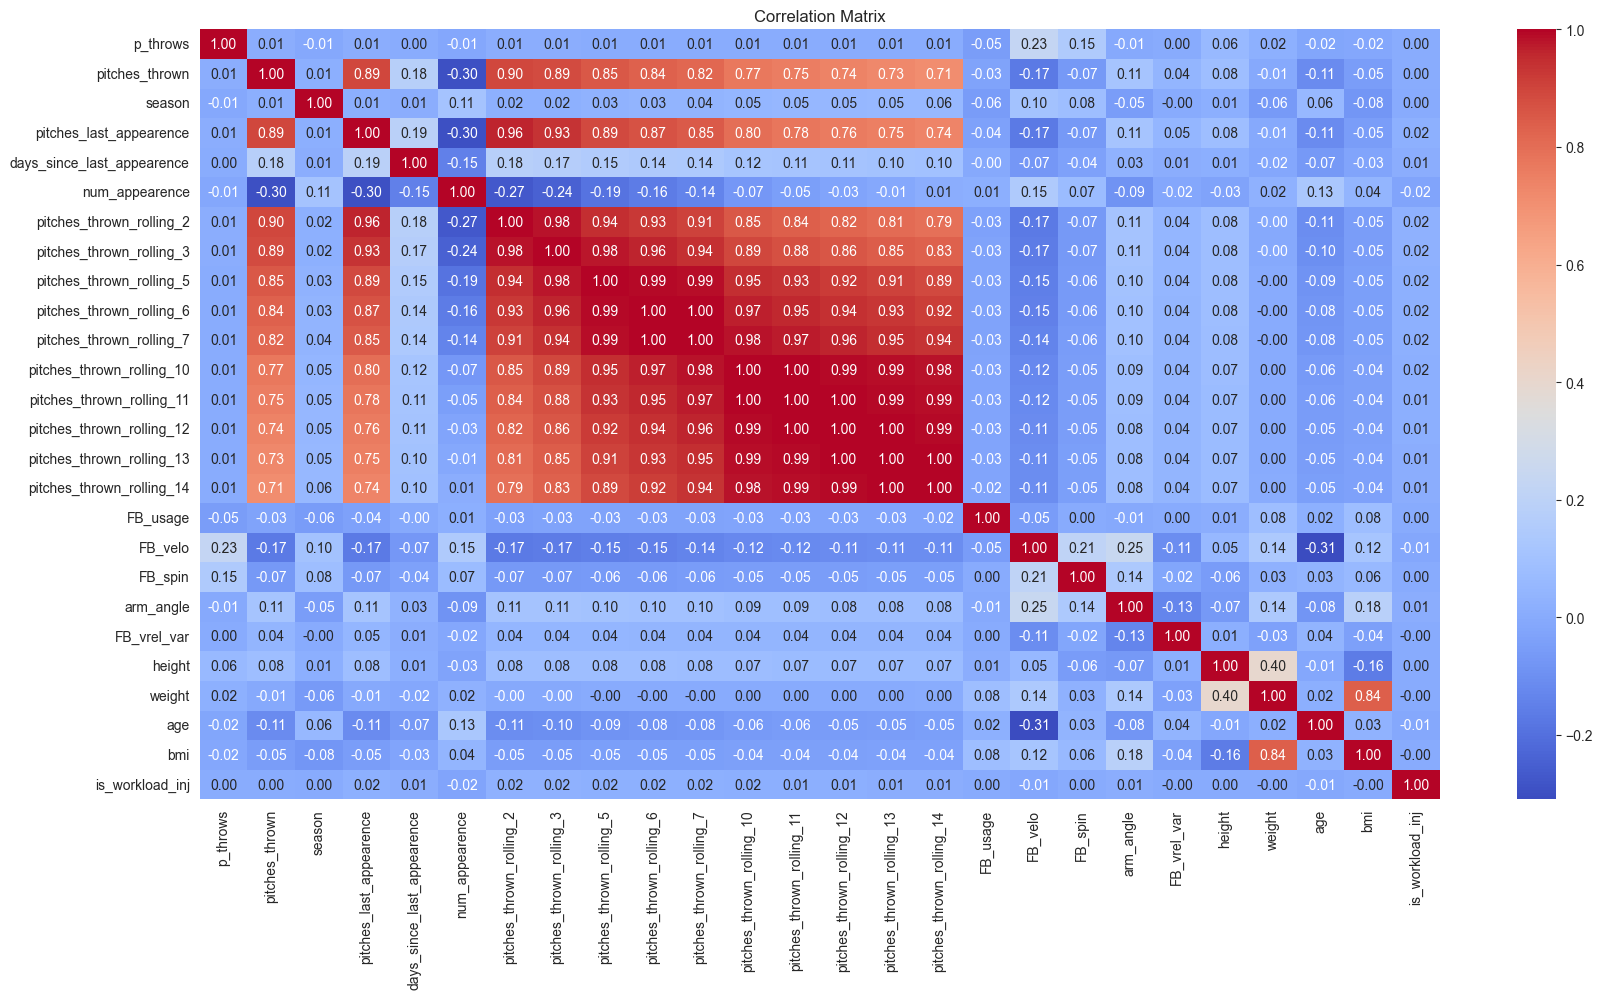

In [51]:
numeric_cols = pitch_injuries.select_dtypes(include='number')
numeric_cols = numeric_cols.drop(columns=['pitcher', 'game_pk', 'birth_year', 'first_appearence']).copy()

corr = numeric_cols.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [52]:
pitch_injuries

,player_name,pitcher,p_throws,game_pk,game_date,pitches_thrown,season,last_appearence_date,pitches_last_appearence,days_since_last_appearence,num_appearence,first_appearence,pitches_thrown_rolling_2,pitches_thrown_rolling_3,pitches_thrown_rolling_5,pitches_thrown_rolling_6,pitches_thrown_rolling_7,pitches_thrown_rolling_10,pitches_thrown_rolling_11,pitches_thrown_rolling_12,pitches_thrown_rolling_13,pitches_thrown_rolling_14,FB_usage,FB_velo,FB_spin,arm_angle,FB_vrel_var,birth_year,birth_country,height,weight,age,bmi,pos,il_type,injury,is_workload_inj
0,albert abreu,656061,1,631234,2020-09-03,2,2020,2020-08-08,41,25.0,2,0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,41.0,0.487805,96.205000,1994.800000,30.885000,0.005837,1995,Dominican Republic,1.879604,86.167800,25,24.390034,NaN,NaN,NaN,0
1,bryan abreu,650556,1,631444,2020-07-29,5,2020,2020-07-26,31,2.0,2,0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.258065,93.275000,2320.875000,42.175000,0.018812,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
2,bryan abreu,650556,1,631391,2020-07-31,16,2020,2020-07-29,5,1.0,3,0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,0.200000,93.600000,2292.000000,43.600000,0.012621,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
3,bryan abreu,650556,1,630109,2020-08-04,24,2020,2020-07-31,16,3.0,4,0,21.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,52.0,0.375000,92.583333,2297.500000,40.750000,0.006430,1997,Dominican Republic,1.854204,104.308390,23,30.339216,NaN,NaN,NaN,0
4,jason adam,592094,1,631621,2020-08-19,40,2020,2020-08-16,25,2.0,2,0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,0.720000,95.150000,2712.888889,22.177778,0.010445,1991,USA,1.905004,103.854875,29,28.617731,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107320,jacob degrom,594798,1,776508,2025-08-31,79,2025,2025-08-25,90,5.0,26,0,174.0,273.0,461.0,547.0,637.0,913.0,997.0,1079.0,1160.0,1241.0,0.411111,97.681081,2470.648649,30.475676,0.001447,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107321,jacob degrom,594798,1,776432,2025-09-06,97,2025,2025-08-31,79,5.0,27,0,169.0,253.0,448.0,540.0,626.0,903.0,992.0,1076.0,1158.0,1239.0,0.518987,97.253659,2488.219512,29.336585,0.001912,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107322,jacob degrom,594798,1,776359,2025-09-12,88,2025,2025-09-06,97,5.0,28,0,176.0,266.0,449.0,545.0,637.0,908.0,1000.0,1089.0,1173.0,1255.0,0.412371,97.325000,2518.125000,30.020000,0.001525,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0
107323,jacob degrom,594798,1,776292,2025-09-17,93,2025,2025-09-12,88,4.0,29,0,185.0,264.0,438.0,537.0,633.0,901.0,996.0,1088.0,1177.0,1261.0,0.556818,97.971429,2545.346939,31.726531,0.001556,1988,USA,1.930404,81.632653,37,21.906226,NaN,NaN,NaN,0


In [53]:
feature_cols = ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var', 'birth_country', 'age', 'bmi']
y = ['is_workload_inj']